In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import GRU, Dense
from keras.optimizers import Adam
from joblib import dump
import os
import glob

In [10]:
ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
DATA_DIR = os.path.join(ROOT_DIR, '..', '..', 'data', 'processed')

data_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))

NameError: name '__file__' is not defined

In [3]:
test_split = round(len(df) * 0.3)
train_data = df[:-test_split]
test_data = df[-test_split:]

print(train_data)
print(test_data)

                           date  temperature  relative_humidity  dew_point  \
0     2023-06-25 19:07:30+00:00         25.1                 45       12.4   
1     2023-06-25 19:33:48+00:00         24.2                 43       10.9   
2     2023-06-25 19:45:44+00:00         24.2                 43       10.9   
3     2023-06-25 19:55:29+00:00         24.2                 43       10.9   
4     2023-06-25 20:02:16+00:00         24.2                 43       10.9   
...                         ...          ...                ...        ...   
13079 2023-09-05 17:03:05+00:00         23.6                 43       10.3   
13080 2023-09-05 17:08:46+00:00         23.6                 43       10.3   
13081 2023-09-05 17:13:12+00:00         23.6                 43       10.3   
13082 2023-09-05 17:16:31+00:00         23.6                 43       10.3   
13083 2023-09-05 17:23:16+00:00         23.6                 43       10.3   

       apparent_temperature  precipitation_probability  rain  \

In [4]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['available_bike_stands']].values)
test_scaled = scaler.transform(test_data[['available_bike_stands']].values)


In [5]:
window_size = 100

def create_window_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), 0]
        label = data[i + window_size, 0]
        X.append(window)
        y.append(label)
    return np.array(X), np.array(y).reshape(-1, 1)

X_train, y_train = create_window_data(train_scaled, window_size)
X_test, y_test = create_window_data(test_scaled, window_size)

X_train = X_train.reshape(-1, 1, window_size)
X_test = X_test.reshape(-1, 1, window_size)

In [6]:
model = Sequential([
    GRU(8, activation='relu', input_shape=(1, window_size), return_sequences=True),
    BatchNormalization(),
    Dense(8, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), verbose=2)

c:\Users\bruli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
406/406 - 7s - 17ms/step - loss: 0.2274 - val_loss: 0.0539
Epoch 2/40
406/406 - 2s - 4ms/step - loss: 0.0226 - val_loss: 0.0321
Epoch 3/40
406/406 - 2s - 4ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 4/40
406/406 - 2s - 4ms/step - loss: 0.0112 - val_loss: 0.0120
Epoch 5/40
406/406 - 2s - 4ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 6/40
406/406 - 2s - 4ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 7/40
406/406 - 2s - 4ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 8/40
406/406 - 2s - 4ms/step - loss: 0.0069 - val_loss: 0.0076
Epoch 9/40
406/406 - 2s - 4ms/step - loss: 0.0068 - val_loss: 0.0101
Epoch 10/40
406/406 - 2s - 4ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 11/40
406/406 - 2s - 4ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 12/40
406/406 - 2s - 4ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 13/40
406/406 - 2s - 4ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 14/40
406/406 - 2s - 4ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 15/40
406/406 - 2s - 4

In [7]:
model.save('../models/model.h5')
dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']

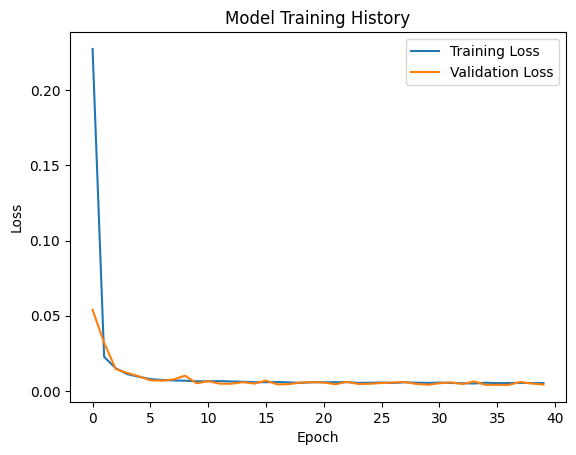

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
def evaluate_model(X, y, scaler, model, set_name="test"):
    predictions = model.predict(X)
    predictions = predictions.reshape(-1, 1)
    predictions_inverse = scaler.inverse_transform(predictions)
    y_inverse = scaler.inverse_transform(y)

    mae = mean_absolute_error(y_inverse, predictions_inverse)
    mse = mean_squared_error(y_inverse, predictions_inverse)
    evs = explained_variance_score(y_inverse, predictions_inverse)
    
    print(f"{set_name} - MAE: {mae}, MSE: {mse}, EVS: {evs}")
    
    if not os.path.exists('reports'):
        os.makedirs('reports')
    
    filename = f"reports/{set_name}_metrics.txt"
    
    with open(filename, "w") as f:
        f.write(f"MAE: {mae}\n")
        f.write(f"MSE: {mse}\n")
        f.write(f"EVS: {evs}\n")
        
    plt.figure(figsize=(10, 5))
    plt.plot(y_inverse.flatten(), label='Actual Values')
    plt.plot(predictions_inverse.flatten(), label='Predicted Values', alpha=0.75)
    plt.title(f'{set_name.capitalize()} Set Predictions vs Actuals')
    plt.xlabel('Sample Index')
    plt.ylabel('Available Bike Stands')
    plt.legend()
    plt.show()

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
test - MAE: 1.021033993765939, MSE: 2.0303458344749825, EVS: 0.9604853183480159


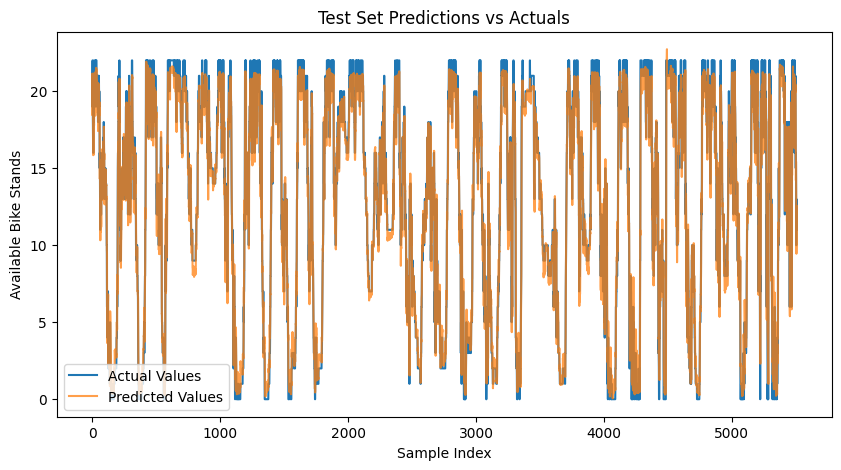

406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
train - MAE: 0.8118036780931005, MSE: 1.2424437494679335, EVS: 0.9688427475166651


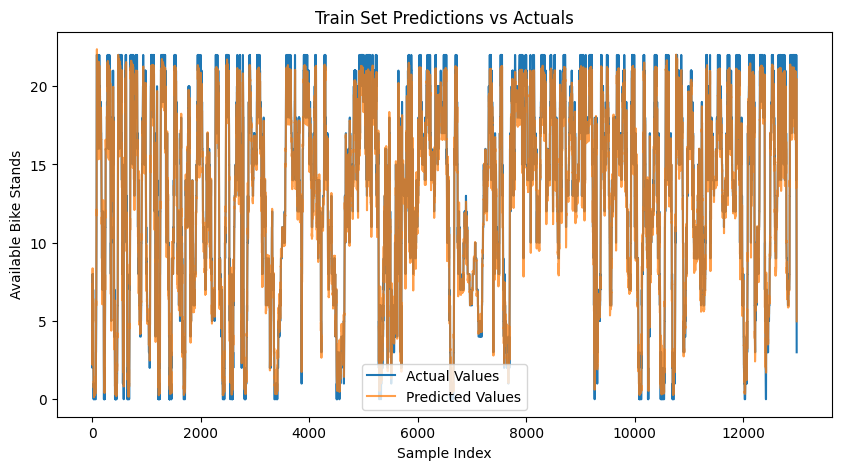

In [11]:
evaluate_model(X_test, y_test, scaler, model, "test")
evaluate_model(X_train, y_train, scaler, model, "train")